In [1]:
"""
Desc:
    MSE vs delta with the increasing number of samples 
Configs:
    # Params
    num_actions=4, 
    action_delta2_ary = np.arange(0, 5.25, .25)
    action_mus_ary = [[mu1]*2 + [mu1-delta2]*2 for delta in action_delta2_ary]
    action_sigma=10,
    num_samples_mu1 = 1000
Status:
"""
from collections import defaultdict
import random
import numpy as np
np.set_printoptions(precision=2, suppress=True)

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("ticks")
sns.set_palette("tab20")
colors = sns.color_palette("bright")

import time 
import multiprocessing

from algos import *
from bandit_problem import *

In [2]:

manager = multiprocessing.Manager()
error_list = manager.list()

def run_trial(
        i_trial, bandit_problem, estimator, num_actions, num_samples_list, args):
    
    random.seed(10000 + i_trial)
    np.random.seed(10000 + i_trial)
    
    # generate rewards
    action_rewards_list = []
    for action_idx in range(num_actions):
        action_idx_rewards = bandit_problem.get_action_rewards(
            action_idx, num_samples_list[action_idx]).ravel()
        
        action_rewards_list.append(action_idx_rewards)
        # print(action_idx_rewards.shape)
            
    action_muhats_list = []
    action_sigmahats_list = []
    for action_idx in range(num_actions):
        action_idx_muhat = np.mean(action_rewards_list[action_idx])
        action_idx_sigmahat = np.std(action_rewards_list[action_idx])
        
        action_muhats_list.append(action_idx_muhat)
        action_sigmahats_list.append(action_idx_sigmahat)
            
    # print(action_muhats_list)
    # print(action_sigmahats_list)
    # print(num_samples_list)
    # stop
    
    # apply estimator
    mu_est = estimator(action_rewards_list, num_actions, num_samples_list, args)    
    # print(mu_est)

    mu_max = np.max(bandit_problem.action_mus)
    # print(mu_max)
    error_list.append(mu_est - mu_max)   

# params
num_actions = 8
num_samples = 100
num_trials = 200

bandit_args = dict() 
reward_dist = "normal"
problem_instance = "multi_gap_nonlinear"
action_sigma = 1.0
action_sigmas = action_sigma*np.ones(num_actions)
gap_splits = [0.5]
gap_deltas = [1.0]
bandit_problem = BanditProblem(
            problem_instance, reward_dist, num_actions, action_sigmas=action_sigmas,
            gap_splits=gap_splits, gap_deltas=gap_deltas)
# print(f"action_mus = {bandit_problem.action_mus}")
# print(f"action_sigmas = {bandit_problem.action_sigmas}")

args = dict()
args["weightedms_num_data"] = 1000
args["haver_alpha"] = 2.0
args["haver_delta"] = 0.05
args["haver_const"] = 1.0
    
pool = multiprocessing.Pool()

action_1_num_samples = 500
num_samples_ary = [10, 50, 100, 250, 500, 1000] 
# num_samples_ary = [10] 
action_delta2_ary = np.arange(0.0, 5.25, .25)
# action_delta2_ary = [5.0]

est_bias_dict = defaultdict(lambda: np.zeros((len(num_samples_ary), len(action_delta2_ary))))
est_var_dict = defaultdict(lambda: np.zeros((len(num_samples_ary), len(action_delta2_ary))))
est_mse_dict = defaultdict(lambda: np.zeros((len(num_samples_ary), len(action_delta2_ary))))

# haver_const_ary = [1.0, 0.25, 0.5, 1.25]
haver_const_ary = [1.0]
haver_name_ary = [f"haver_{x}" for x in haver_const_ary]
haver3_name_ary = [f"haver3_{x}" for x in haver_const_ary]
haver4_name_ary = [f"haver4_{x}" for x in haver_const_ary]
est_name_ary = ["weightedms", "double", "max"]
est_name_ary += haver_name_ary
est_name_ary += haver3_name_ary
est_name_ary += haver4_name_ary
# est_name_ary = ["haver_1.0"]
for est_name in est_name_ary:
    start_time = time.time()
    print(f"\n-> est_name = {est_name}")
    if "haver" in est_name:
        elems = est_name.split("_")
        estimator = create_estimator(elems[0])
        args["haver_const"] = float(elems[-1])
        args["action_sigma"] = action_sigma
    else:
        estimator = create_estimator(est_name)
    reward_fn = create_reward_fn("normal")
        
    for i_N, num_samples in enumerate(num_samples_ary):
        for i_mu, action_delta2 in enumerate(action_delta2_ary):
            # print(f"\n-> num_samples = {num_samples}, action_mus = {action_mus}")
            gap_splits = [0.5]
            gap_deltas = [action_delta2]
            bandit_problem = BanditProblem(
                problem_instance, reward_dist, num_actions, action_sigmas=action_sigmas,
                gap_splits=gap_splits, gap_deltas=gap_deltas)
            # print(bandit_problem.action_mus)
            # print(bandit_problem.action_sigmas)
        
            num_samples_list = [action_1_num_samples] + [num_samples]*(num_actions-1)
            # num_samples_list = [  77,  134, 2213,   21,   11,   18,   15,   11]
            # print(num_samples_list)
            trial_args = [
                (i, bandit_problem, estimator, num_actions, num_samples_list, args) for i in range(num_trials)]
            pool.starmap(run_trial, trial_args)

            error_ary = np.hstack(error_list)
            est_bias = np.mean(error_ary)
            est_var = np.var(error_ary, ddof=1)
            est_mse = est_bias**2 + est_var

            est_bias_dict[est_name][i_N, i_mu] = est_bias
            est_var_dict[est_name][i_N, i_mu] = est_var
            est_mse_dict[est_name][i_N, i_mu] = est_mse
                    
            error_list[:] = []
    
    print(f"mse = {est_mse_dict[est_name][0, -1]:0.2f}")
    print(f"bias = {est_bias_dict[est_name][0, -1]:0.2f}")
    print(f"var = {est_var_dict[est_name][0, -1]:0.2f}")
    end_time = time.time()
    print(f"it takes {end_time-start_time:0.4f}")
    


-> est_name = weightedms
mse = 0.09
bias = 0.20
var = 0.05
it takes 4.3933

-> est_name = double
mse = 0.12
bias = 0.00
var = 0.12
it takes 3.3038

-> est_name = max
mse = 0.12
bias = 0.28
var = 0.05
it takes 3.0322

-> est_name = haver_1.0
mse = 0.01
bias = 0.01
var = 0.01
it takes 3.6572

-> est_name = haver3_1.0
mse = 0.00
bias = -0.00
var = 0.00
it takes 3.7356

-> est_name = haver4_1.0
mse = 0.00
bias = -0.00
var = 0.00
it takes 3.6100


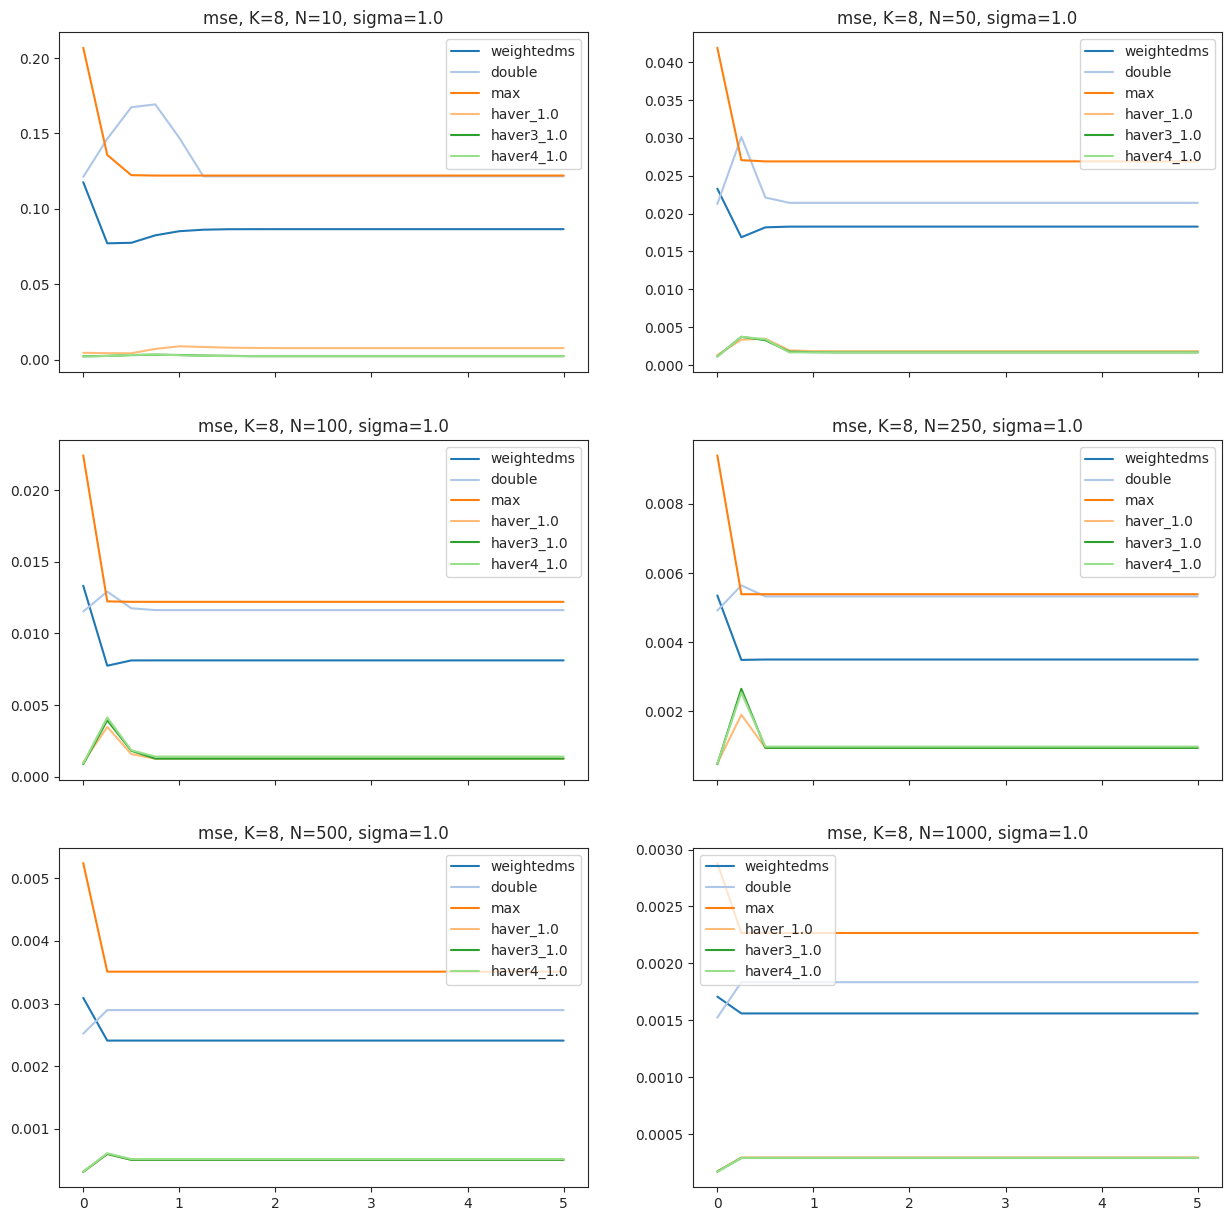

In [3]:
fig, axes = fig, axes = plt.subplots(
        nrows=3, ncols=2, sharex=True, sharey=False, figsize=(15,15))
# axes = [axes]
axes = axes.ravel()

x_ary = action_delta2_ary
substract_list = []
for i_N, num_samples in enumerate(num_samples_ary):
    for est_name in [est_name for est_name in est_name_ary[:8] if est_name not in substract_list]:
        axes[i_N].plot(x_ary, est_mse_dict[est_name][i_N,:], label=est_name)
        axes[i_N].set_title(f"mse, K={num_actions}, N={num_samples}, sigma={action_sigma:0.1f}")
        axes[i_N].legend()
        
plt.show()

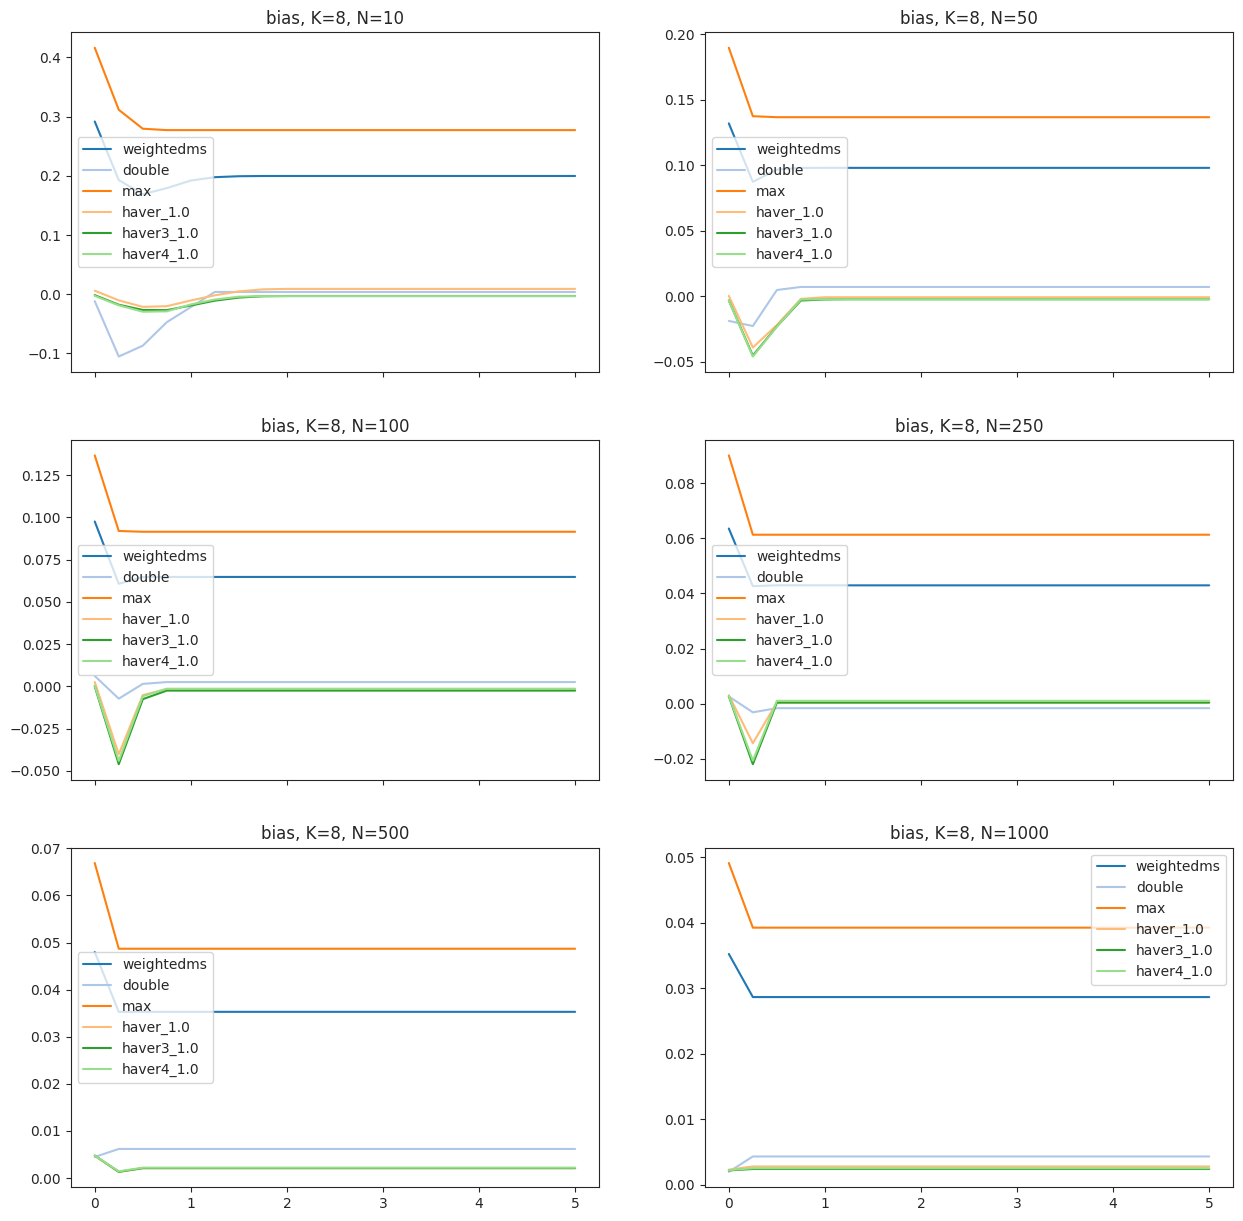

In [4]:
fig, axes = fig, axes = plt.subplots(
        nrows=3, ncols=2, sharex=True, sharey=False, figsize=(15,15))
# axes = [axes]
axes = axes.ravel()

x_ary = action_delta2_ary
for i_N, num_samples in enumerate(num_samples_ary):
    for est_name in est_name_ary:
        axes[i_N].plot(x_ary, est_bias_dict[est_name][i_N,:], label=est_name)
        axes[i_N].set_title(f"bias, K={num_actions}, N={num_samples}")
        axes[i_N].legend()
        
plt.show()

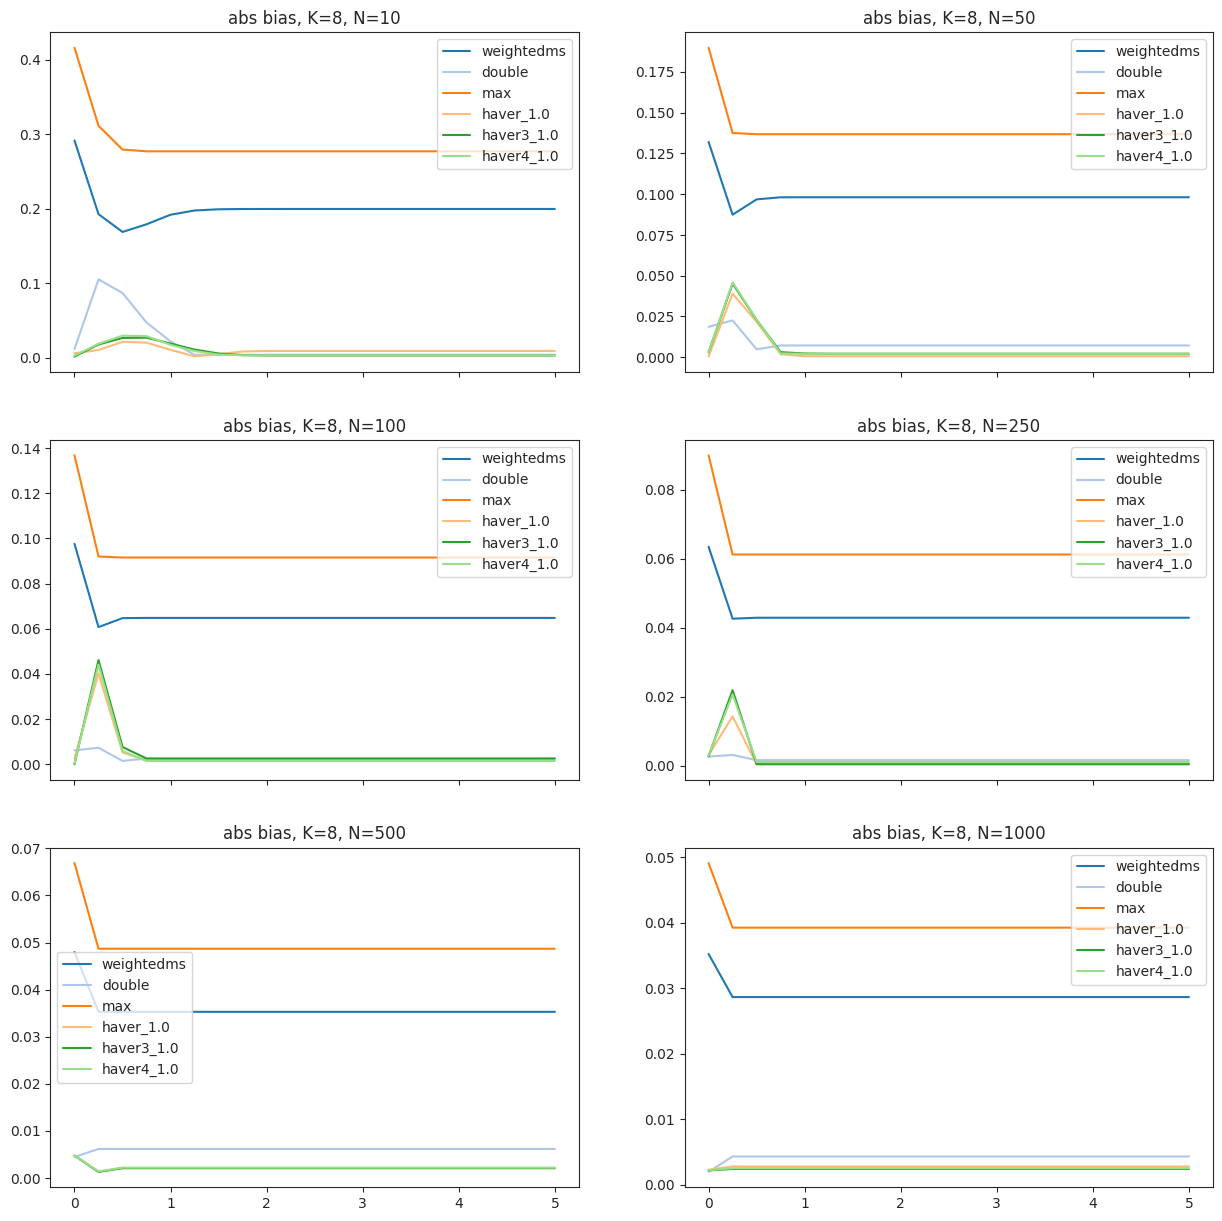

In [5]:
fig, axes = fig, axes = plt.subplots(
        nrows=3, ncols=2, sharex=True, sharey=False, figsize=(15,15))
# axes = [axes]
axes = axes.ravel()

x_ary = action_delta2_ary
for i_N, num_samples in enumerate(num_samples_ary):
    for est_name in est_name_ary:
        axes[i_N].plot(x_ary, np.abs(est_bias_dict[est_name][i_N,:]), label=est_name)
        axes[i_N].set_title(f"abs bias, K={num_actions}, N={num_samples}")
        axes[i_N].legend()
        
plt.show()

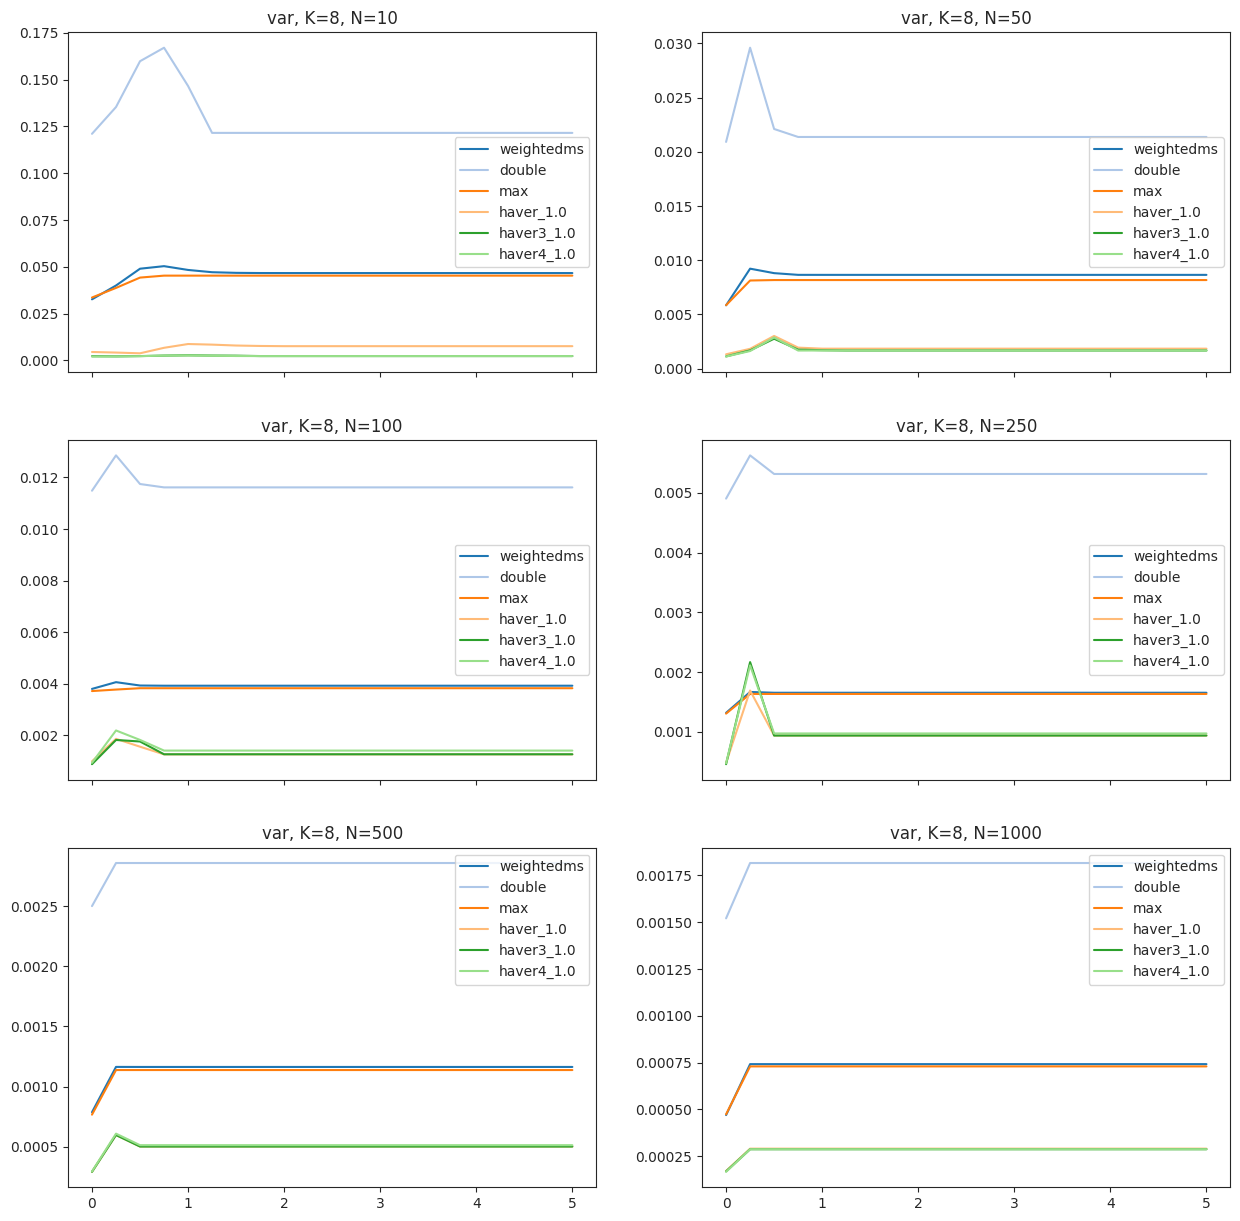

In [6]:
fig, axes = fig, axes = plt.subplots(
        nrows=3, ncols=2, sharex=True, sharey=False, figsize=(15,15))
# axes = [axes]
axes = axes.ravel()

x_ary = action_delta2_ary
for i_N, num_samples in enumerate(num_samples_ary):
    for est_name in est_name_ary:
        axes[i_N].plot(x_ary, np.abs(est_var_dict[est_name][i_N,:]), label=est_name)
        axes[i_N].set_title(f"var, K={num_actions}, N={num_samples}")
        axes[i_N].legend()
        
plt.show()